# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import random 
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import duckdb
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import permutations

#한글 깨짐 방지
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 데이터 불러오기

In [3]:
data_path = Path('../data')

train = pd.read_csv(data_path / 'train.csv')
test = pd.read_csv(data_path / 'test.csv')
train_target = train['support_needs']

#데이터 구조 확인
train.head()



ID   age gender  tenure  frequent  payment_interval  \
0  TRAIN_00000  54.0      F    47.0      22.0               8.0   
1  TRAIN_00001  30.0      M    16.0      15.0               5.0   
2  TRAIN_00002  29.0      M     8.0      30.0              21.0   
3  TRAIN_00003  38.0      F    38.0      23.0              10.0   
4  TRAIN_00004  25.0      F    52.0       3.0              17.0   

  subscription_type  contract_length  after_interaction  support_needs  
0            member               90               25.0              0  
1               vip              360               23.0              0  
2              plus               30               21.0              0  
3               vip               90                6.0              0  
4            member               30                1.0              2

In [36]:
#EDA
train.describe()
train_cols = [col for col in train.columns if 'ID' not in col]

print(train_cols)

['age', 'gender', 'tenure', 'frequent', 'payment_interval', 'subscription_type', 'contract_length', 'after_interaction', 'support_needs']


# EDA

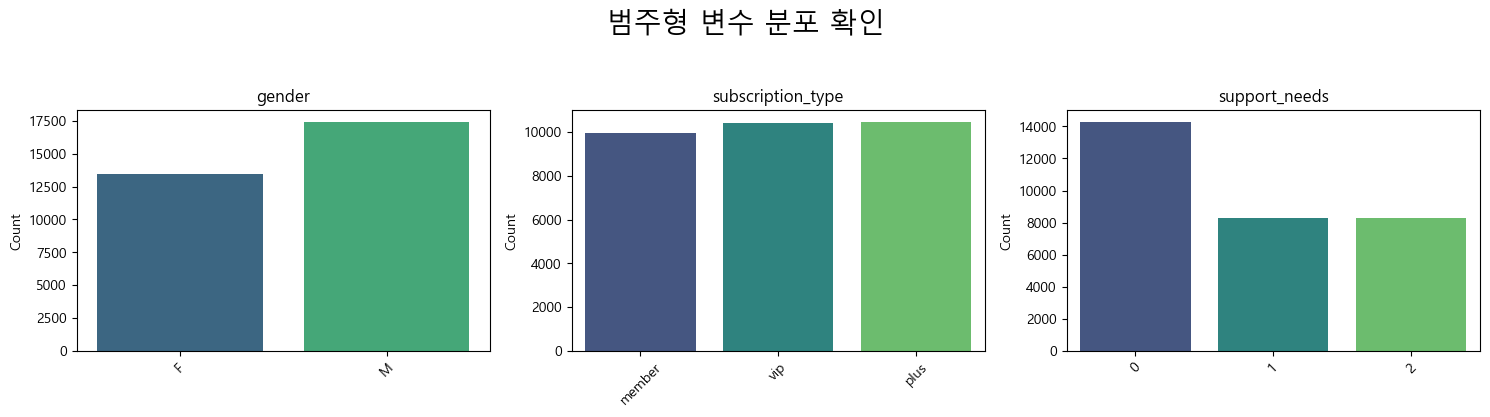

In [5]:
#범주형 변수 리스트
categorical_vars = [
    'gender', 'subscription_type', 'support_needs'
]

#그래프 그리기기
plt.figure(figsize=(15, 10))
plt.suptitle('범주형 변수 분포 확인', fontsize=20)

# 반복문을 통해 각 변수별로 그래프 그리기
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 3, i) # 3x3 격자에 i번째 그래프를 그림
    sns.countplot(x=var, data=train, palette='viridis')
    plt.title(var)
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# support_needs 변수가 불균형하다, 어떻게 해결해야 하지?

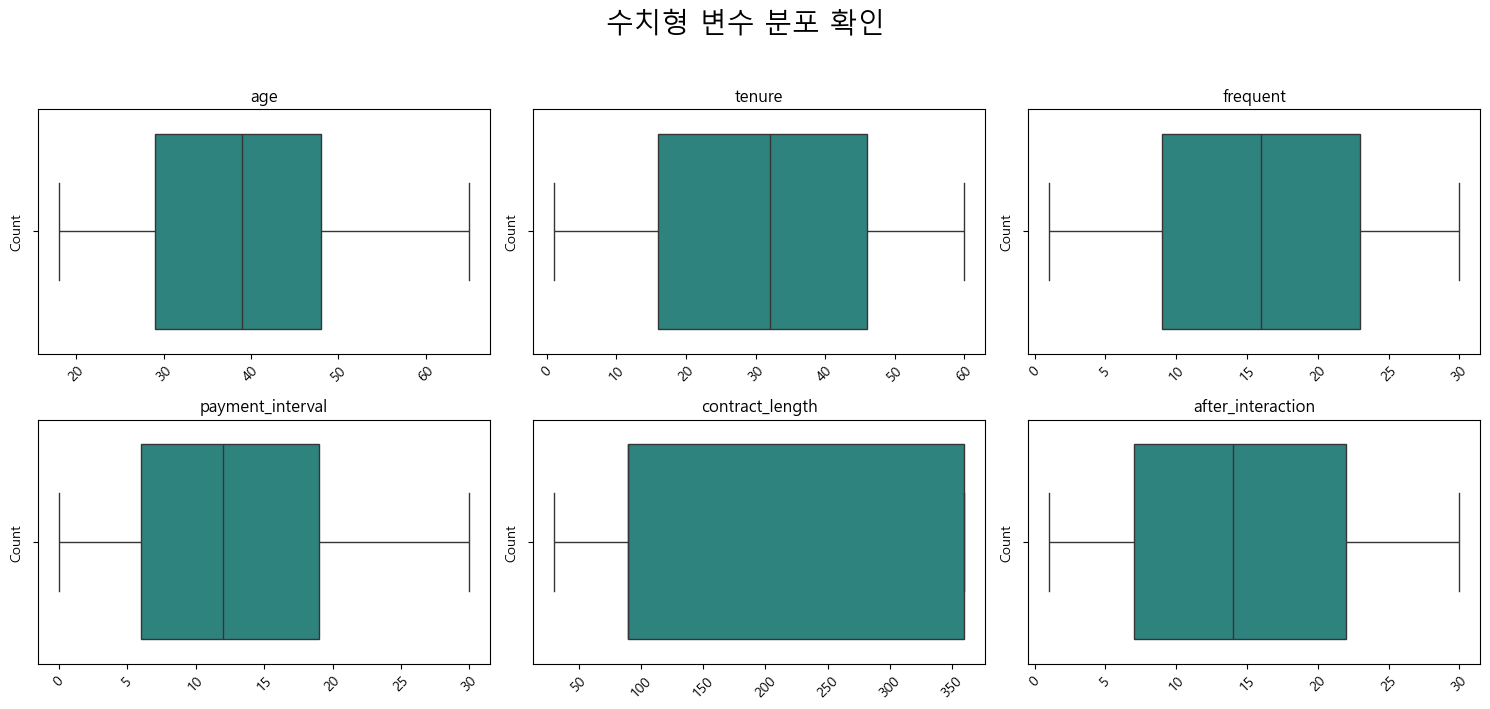

In [6]:
# 수치형 변수 리스트
numerical_vars = ['age', 'tenure', 'frequent', 'payment_interval', 'contract_length', 'after_interaction']

#그래프 그리기
plt.figure(figsize=(15, 10))
plt.suptitle('수치형 변수 분포 확인', fontsize=20)

# 반복문을 통해 각 변수별로 그래프 그리기
for i, var in enumerate(numerical_vars , 1):
    plt.subplot(3, 3, i) # 3x3 격자에 i번째 그래프를 그림
    sns.boxplot(x=var, data=train, palette='viridis')
    plt.title(var)
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# 얼추 다 괜찮게 생긴거같다

In [9]:
# 연속형 - 연속형 상관계수 (피어슨 상관계수)
# 1. 각 변수가 연속형이어야함
# 2. 각 변수가 정규분포여야함
# 정규성 검정 샤피로 - 윌크 검정
import pingouin as pg
for i in numerical_vars:
    print(pg.normality(train[i]))


            W          pval  normal
age  0.973539  7.311240e-58   False
               W          pval  normal
tenure  0.953519  3.533886e-69   False
                 W          pval  normal
frequent  0.954784  1.338857e-68   False
                         W          pval  normal
payment_interval  0.962587  1.071823e-64   False
                        W           pval  normal
contract_length  0.710029  4.047622e-113   False
                         W          pval  normal
after_interaction  0.95252  1.261306e-69   False


# 망했지만 그래도 해보죠 뭐

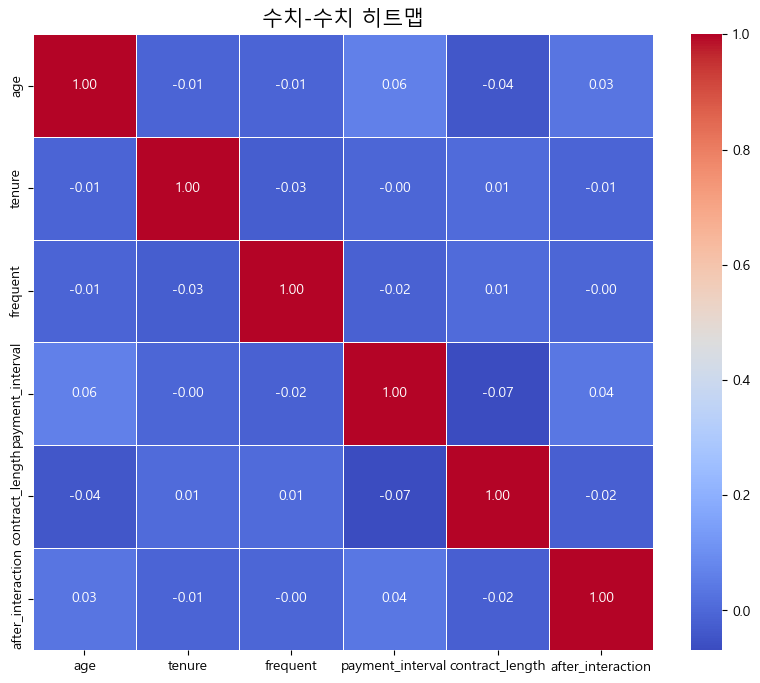

In [10]:
# 수치형 변수들 히트맵 그리기
corr_matrix_numerical = train[numerical_vars].corr()

# 2. 히트맵 그리기
plt.figure(figsize=(10, 8)) # 그래프 크기 설정
sns.heatmap(
    corr_matrix_numerical,
    annot=True,      # 각 셀에 값(상관계수) 표시
    cmap='coolwarm', # 색상 스타일 지정 (양수는 붉은색, 음수는 푸른색)
    fmt='.2f',       # 소수점 둘째 자리까지 표시
    linewidths=.5    # 셀 사이의 경계선 두께
)
plt.title('수치-수치 히트맵', fontsize=15)
plt.show()

# 수치형끼리는 전부 다 상관성이 없어 보임

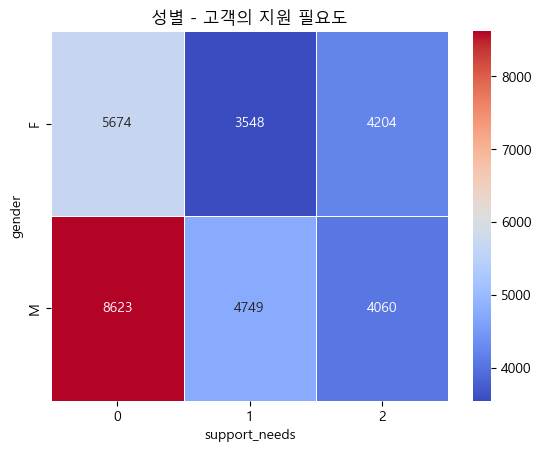

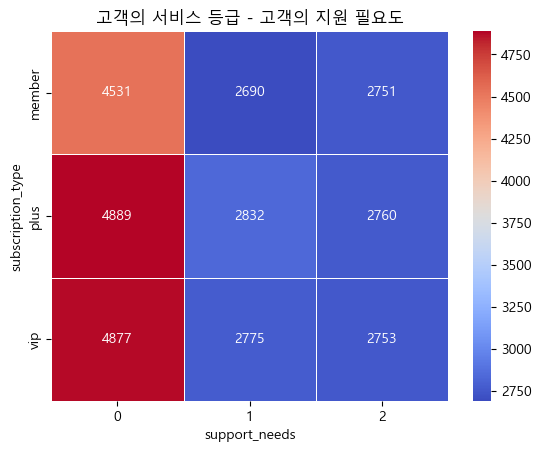

In [11]:
# 범주형 - 범주형 상관계수

# 성별 - 고객의 지원 필요도
cross_table = pd.crosstab(train['gender'],train['support_needs'])
sns.heatmap(cross_table, annot=True, cmap ='coolwarm',fmt='d',linewidths=.5 )
plt.title('성별 - 고객의 지원 필요도')
plt.show()

# 고객의 서비스 등급 - 고객의 지원 필요도
cross_table = pd.crosstab(train['subscription_type'],train['support_needs'])
sns.heatmap(cross_table, annot=True, cmap ='coolwarm',fmt='d',linewidths=.5  )
plt.title('고객의 서비스 등급 - 고객의 지원 필요도')
plt.show()

# support_needs 에 0이 많아서 그래보이는 듯?

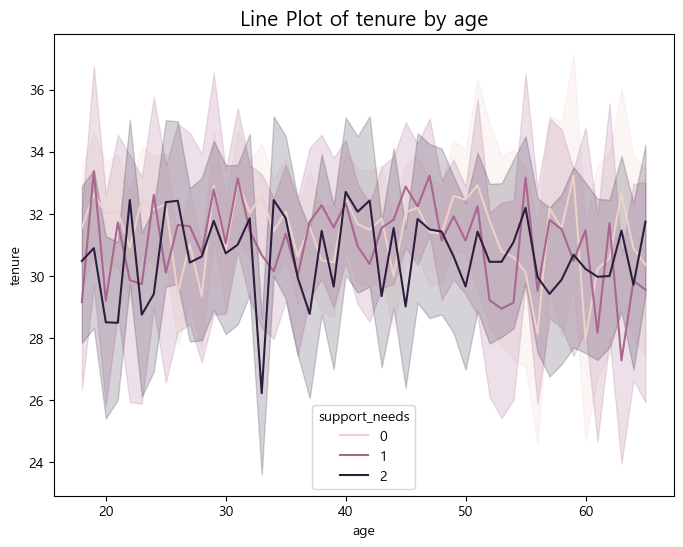

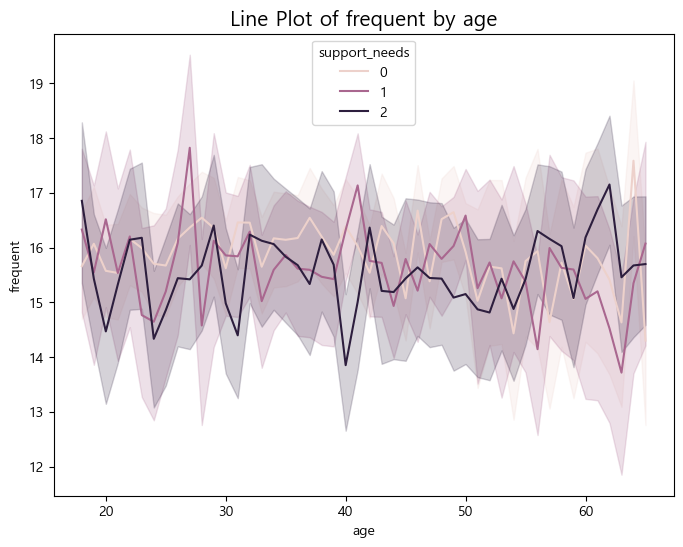

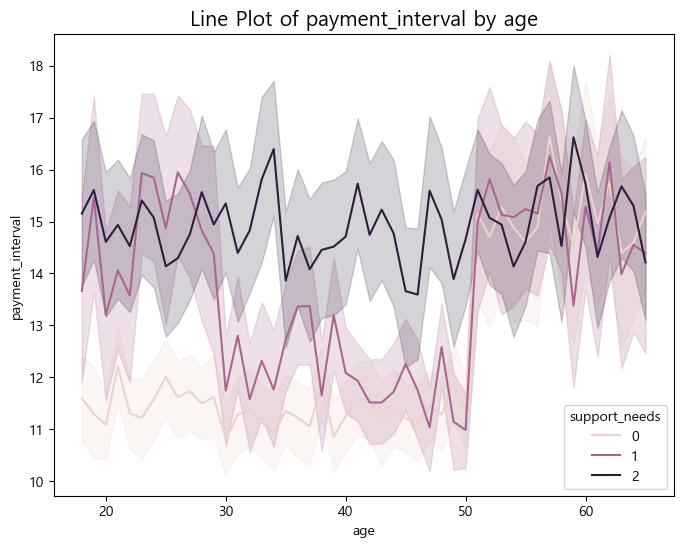

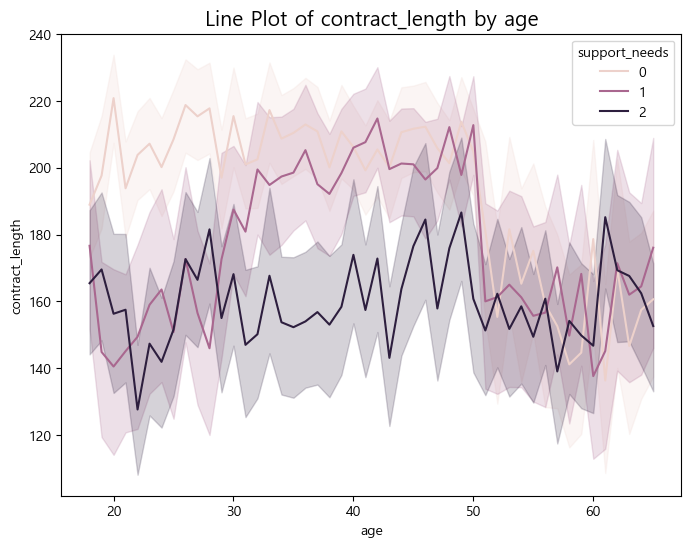

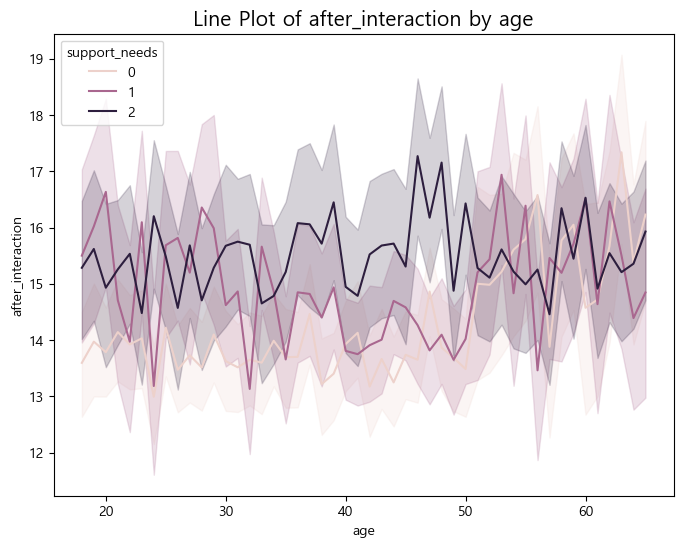

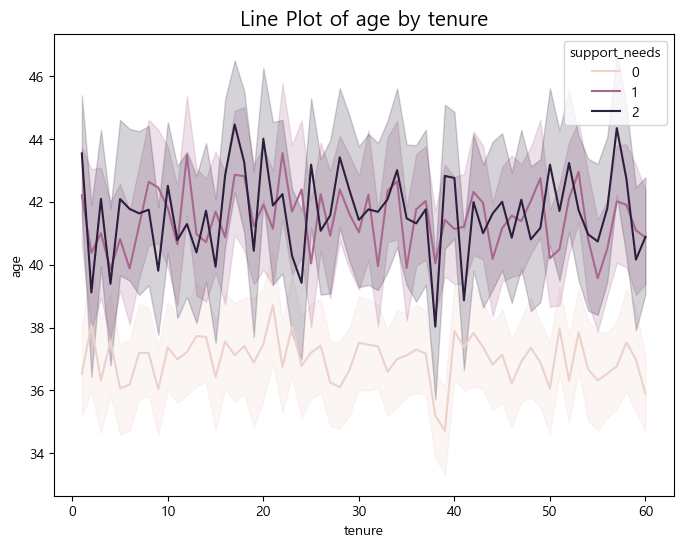

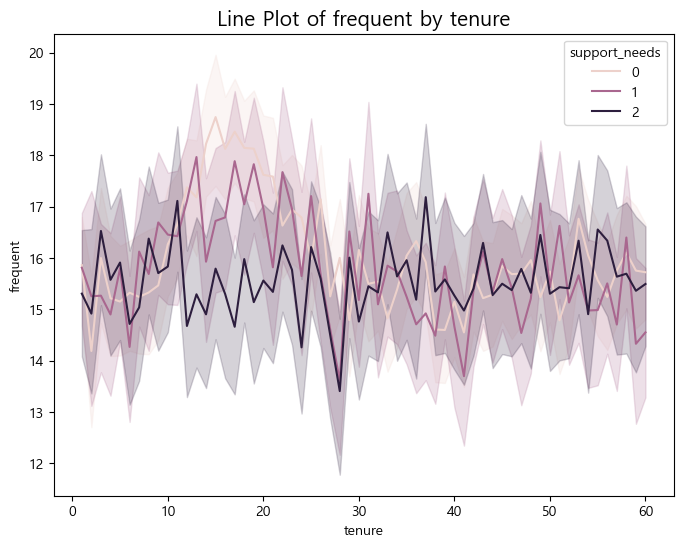

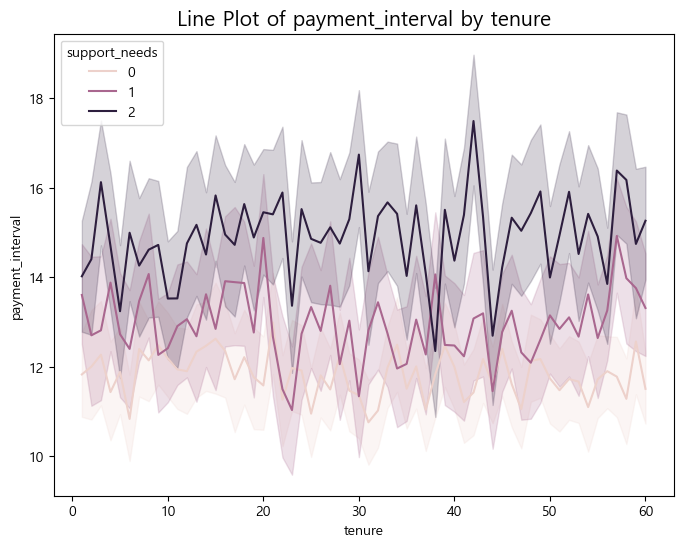

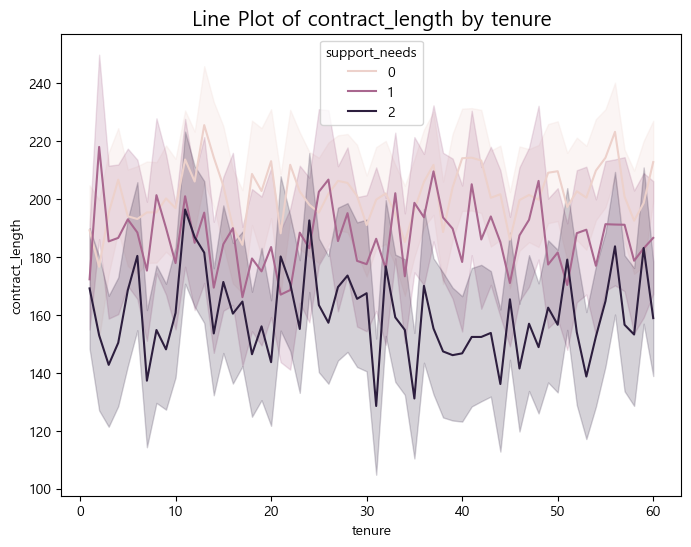

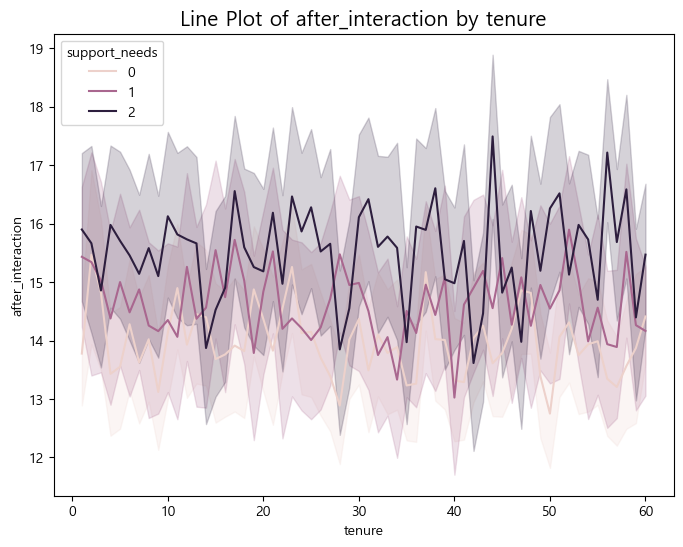

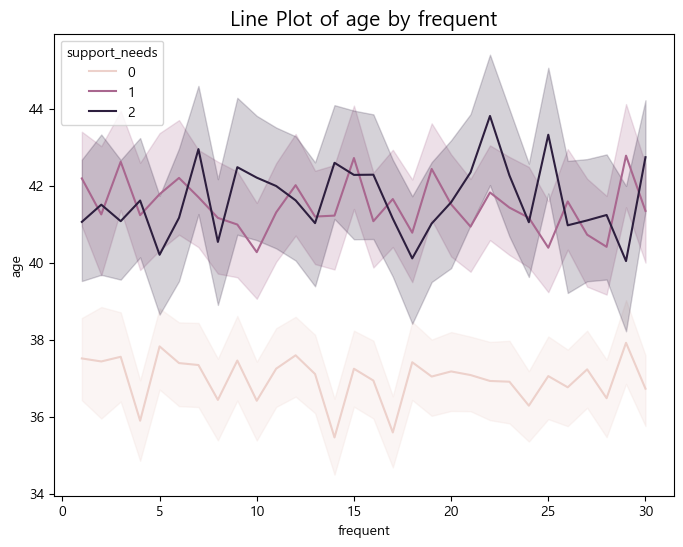

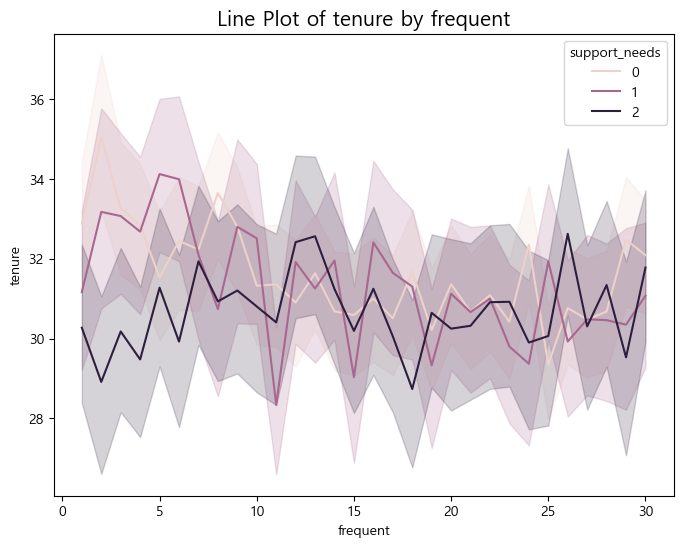

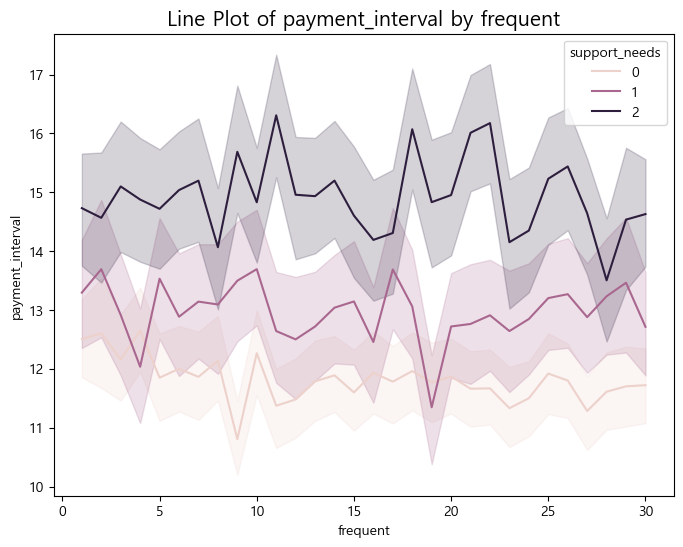

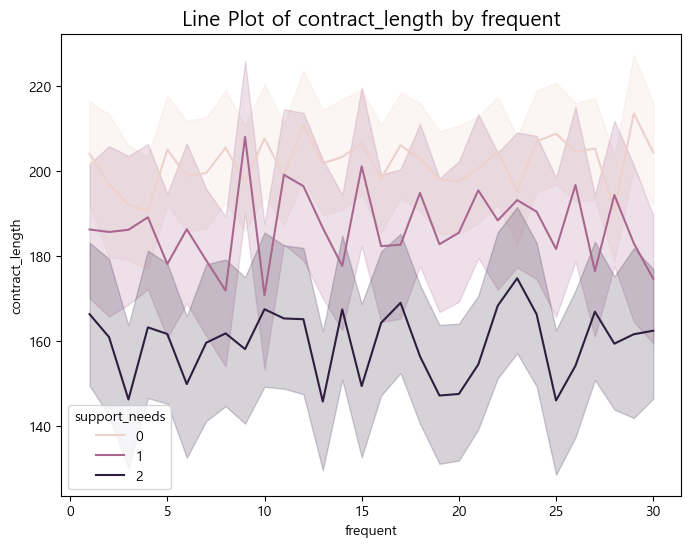

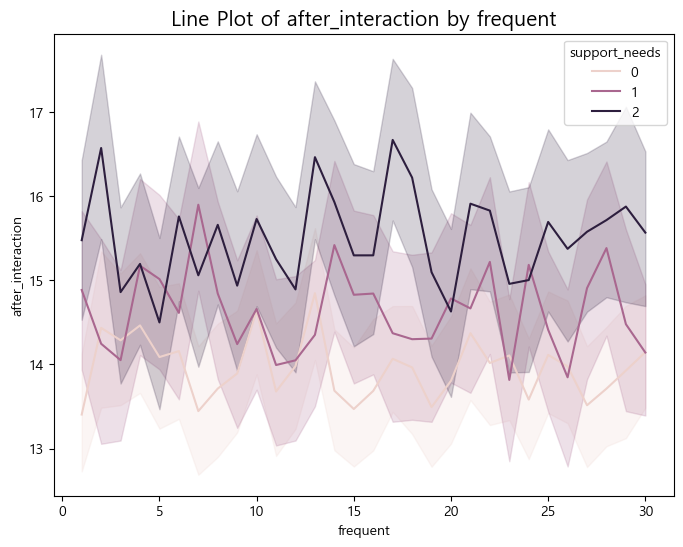

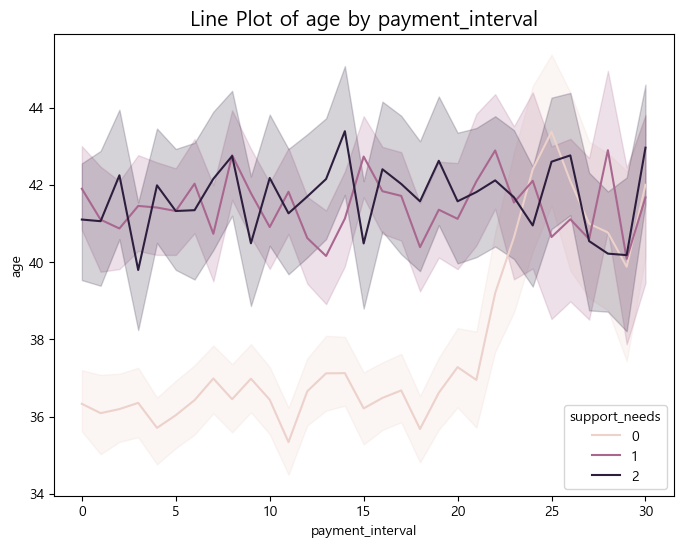

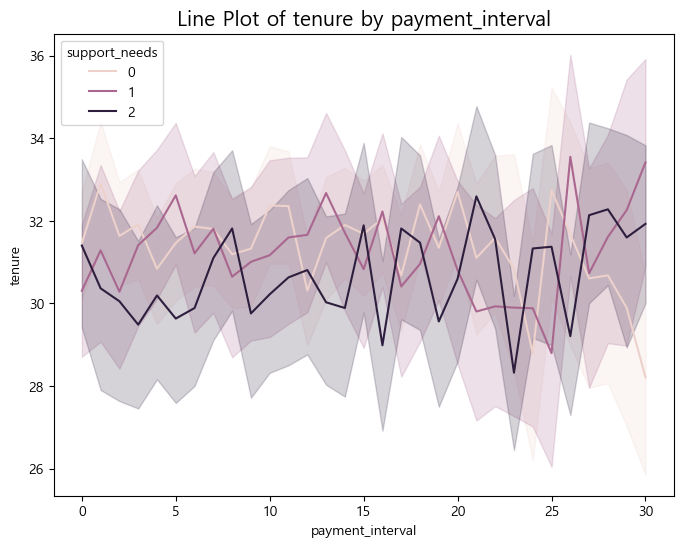

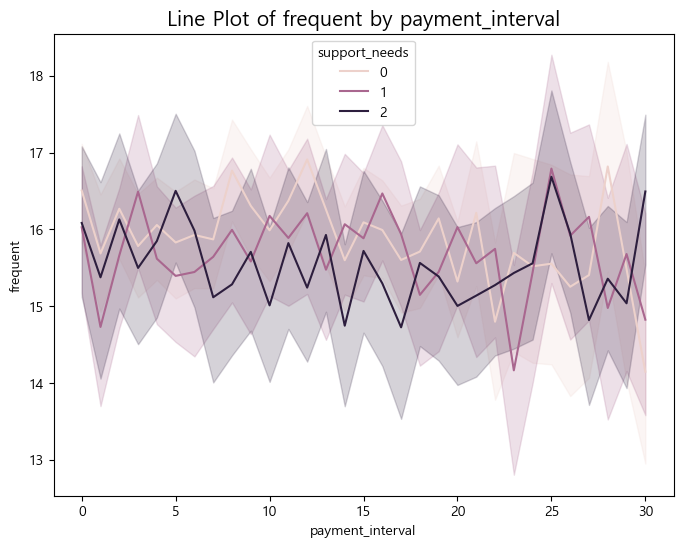

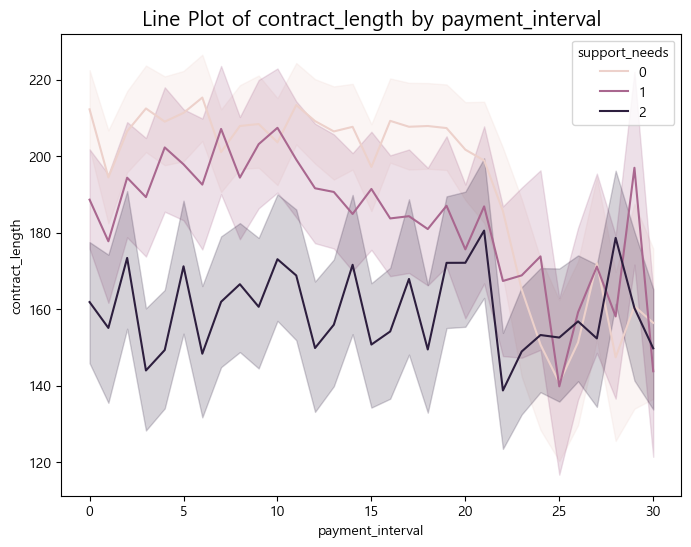

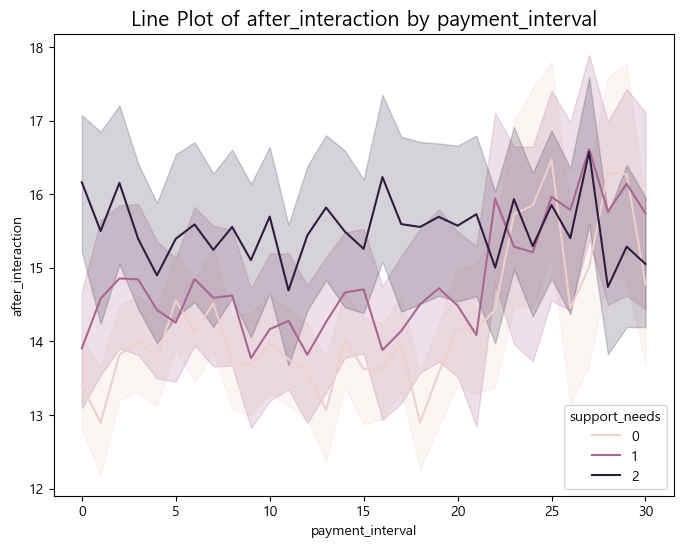

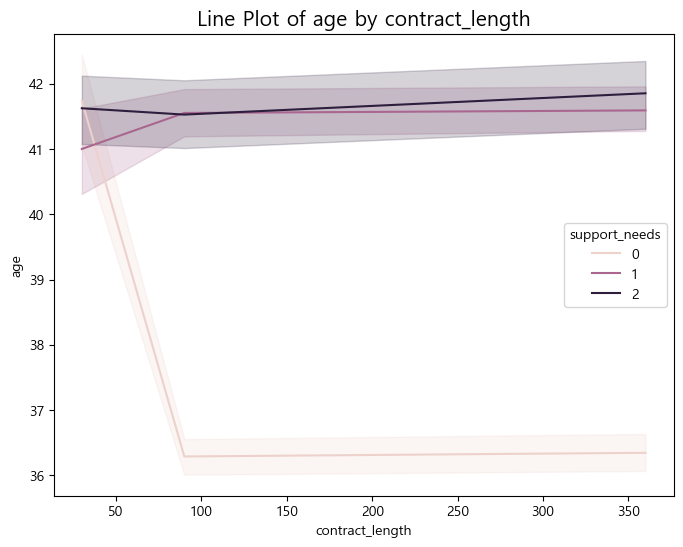

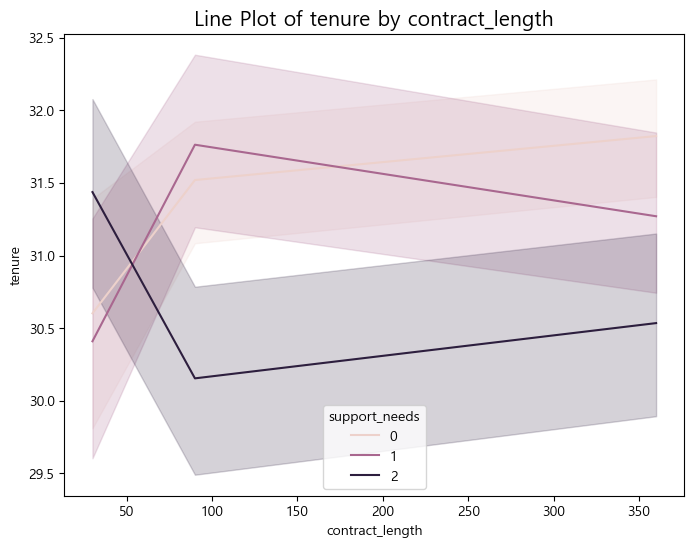

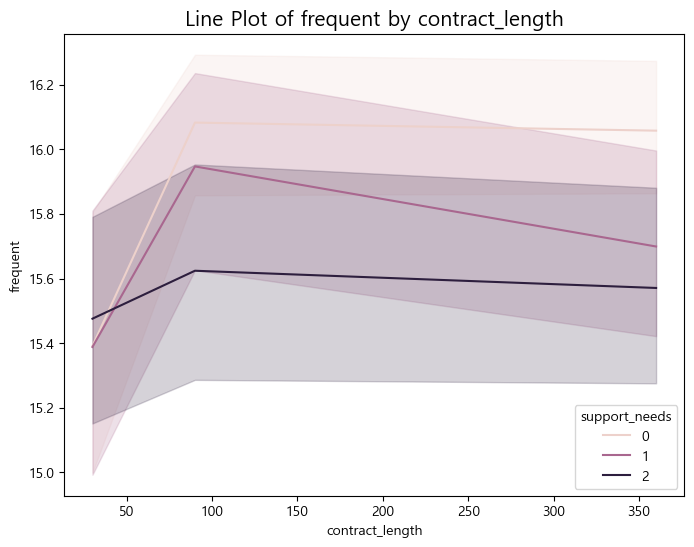

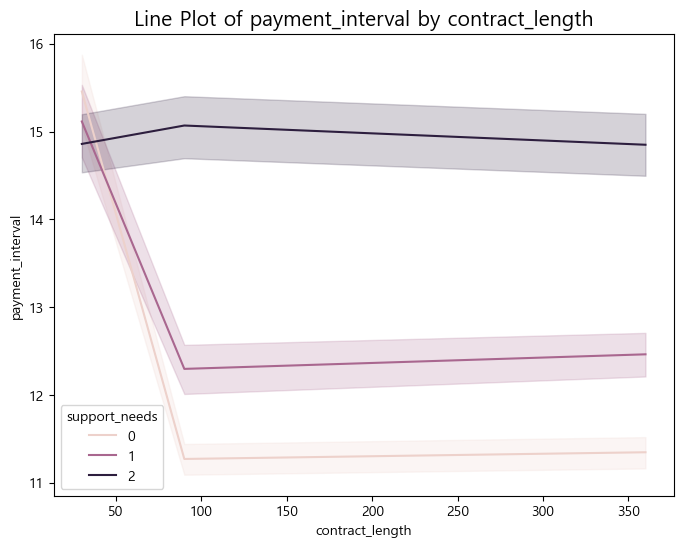

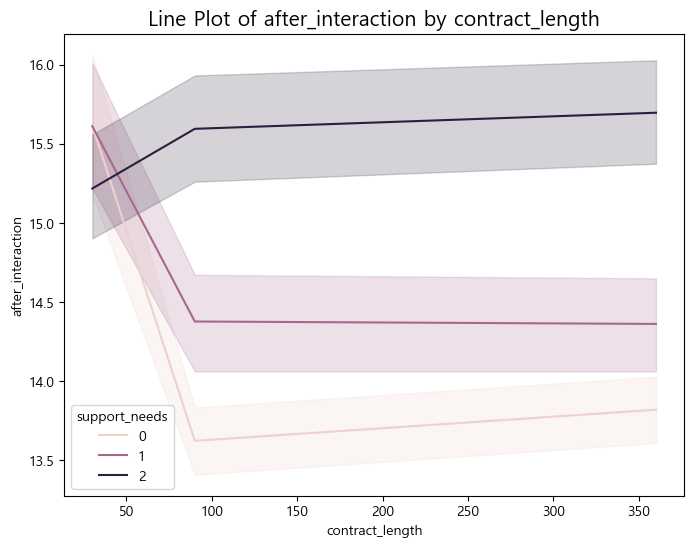

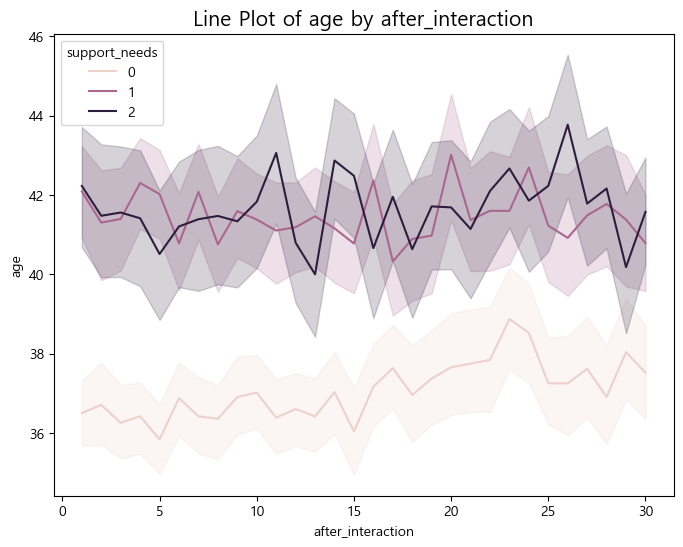

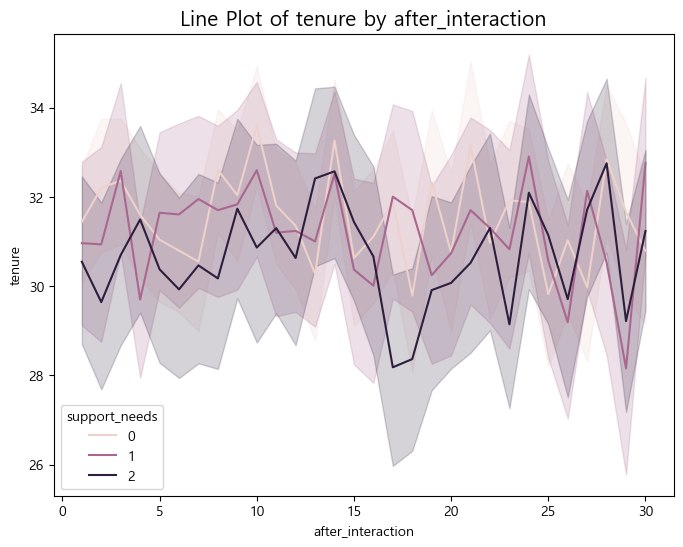

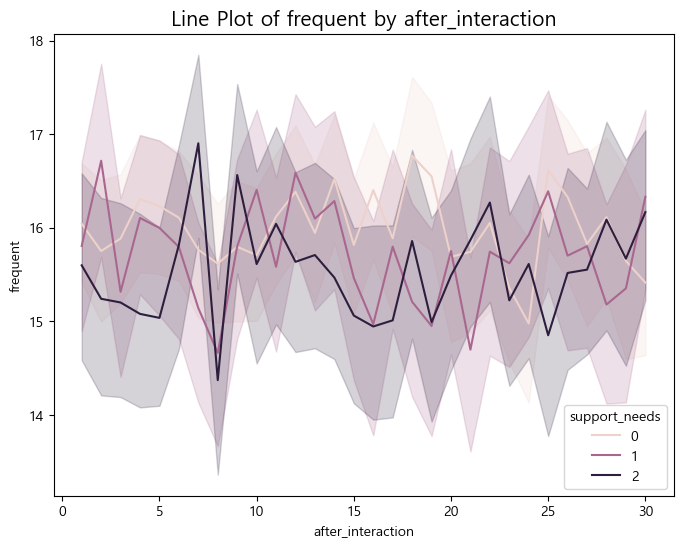

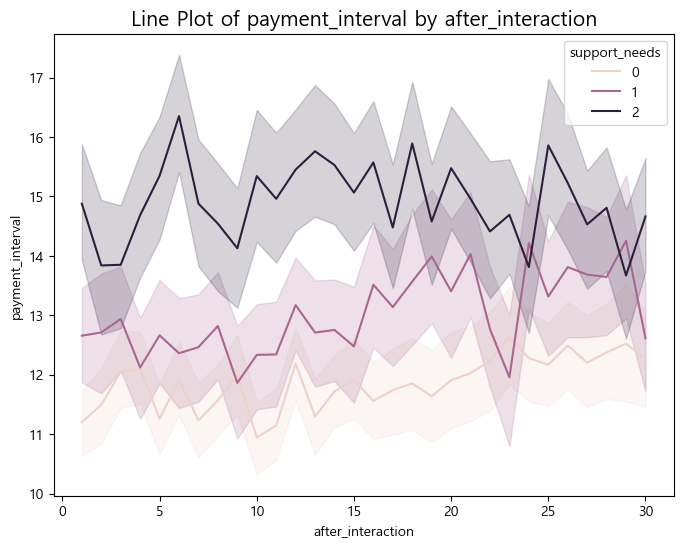

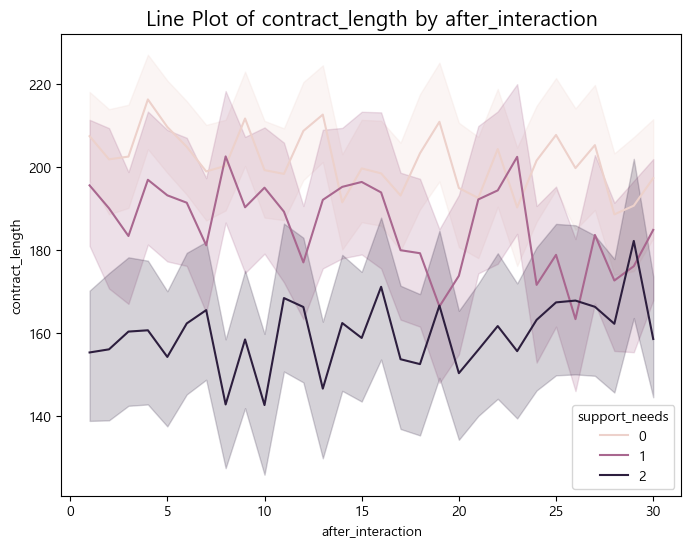

In [12]:
# 고객지원등급 별로 차이가 있나?
from itertools import permutations

var_combinations = permutations(numerical_vars, 2)

for x_var, y_var in var_combinations:
    plt.figure(figsize=(8, 6)) # 각 그래프를 새로운 창에 그리기 위해 figure 생성
    
    sns.lineplot(
        x=x_var,
        y=y_var,
        hue='support_needs',
        data=train
    )
    
    plt.title(f'Line Plot of {y_var} by {x_var}', fontsize=15)
    plt.show()


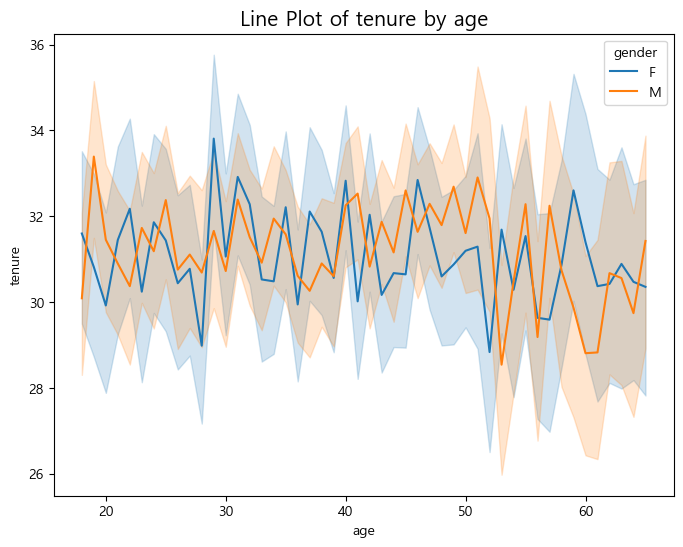

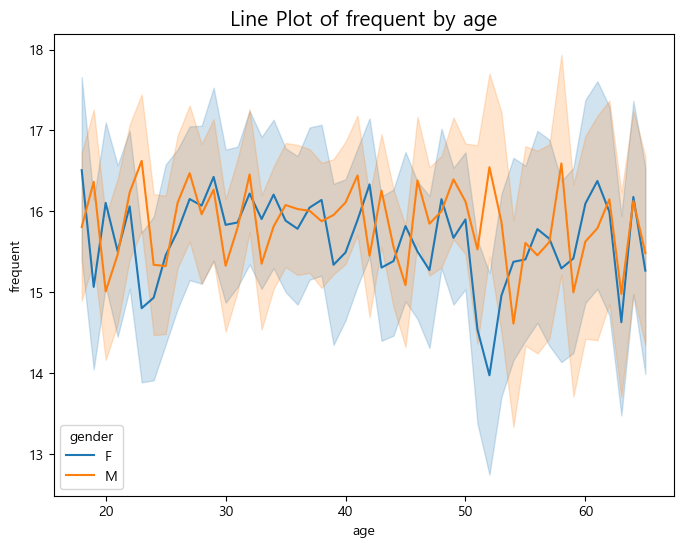

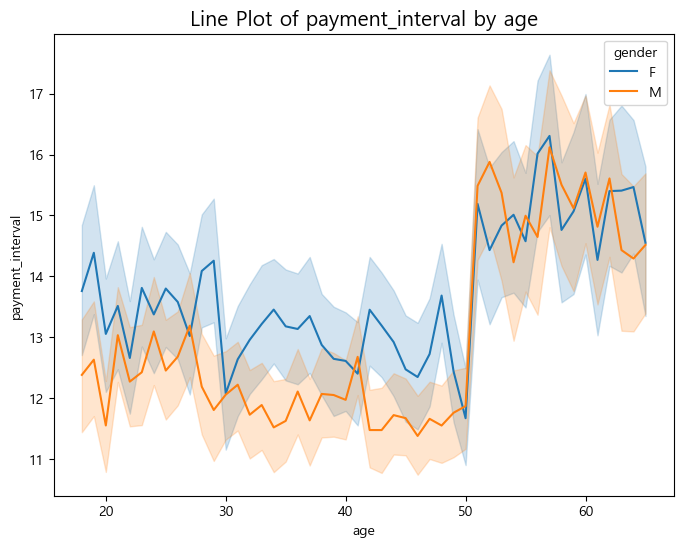

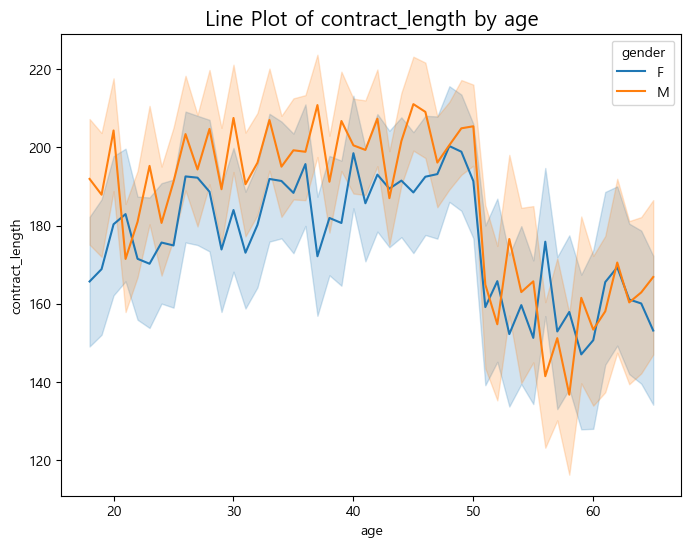

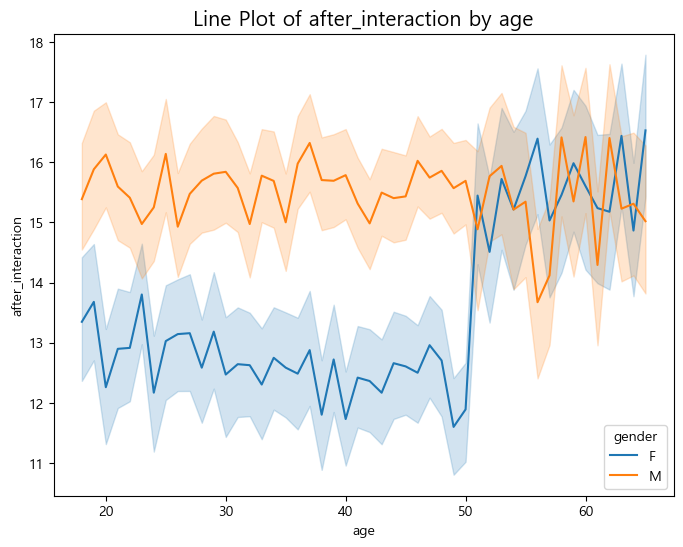

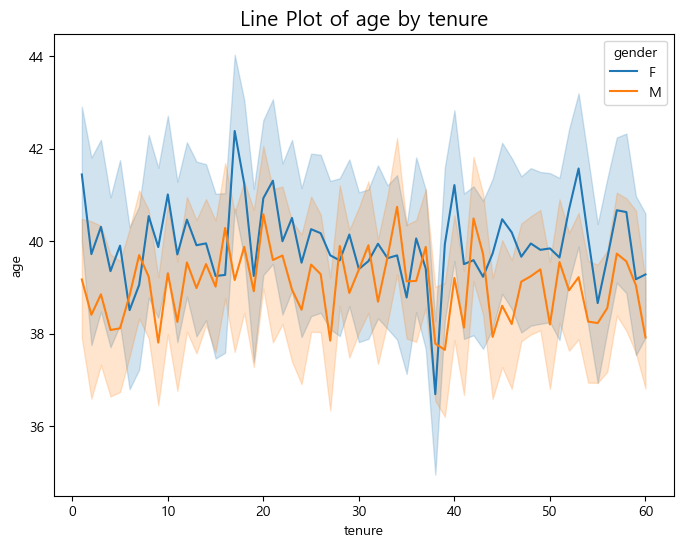

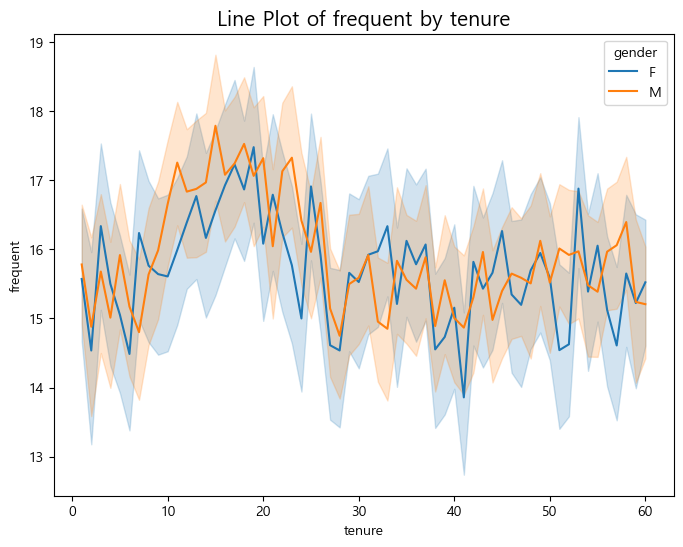

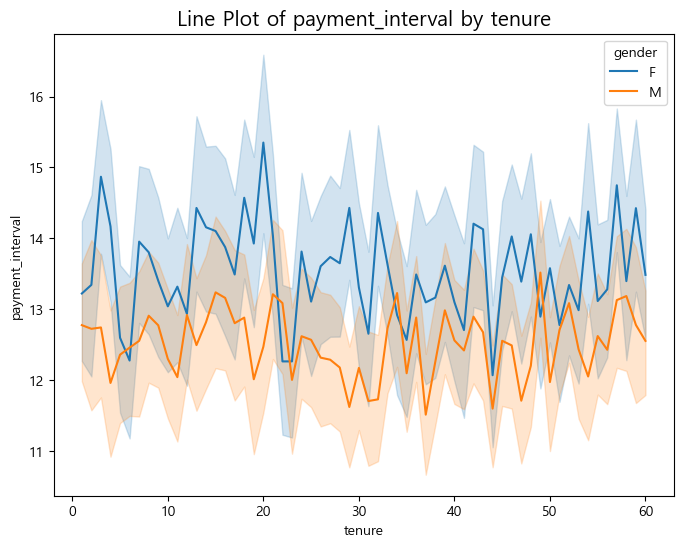

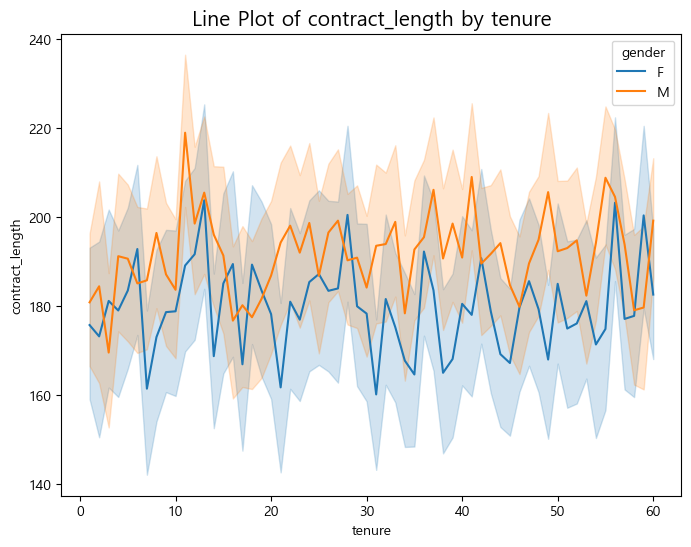

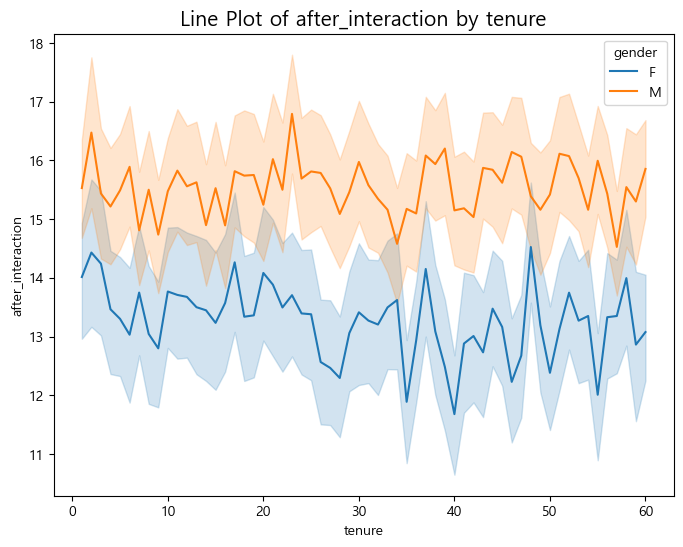

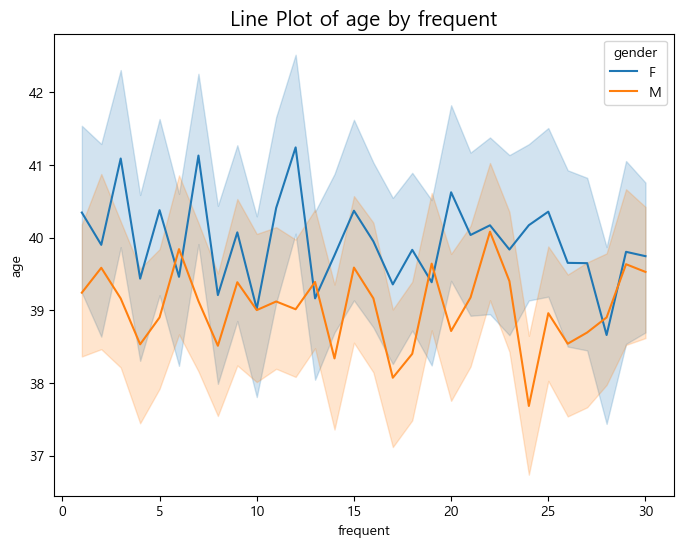

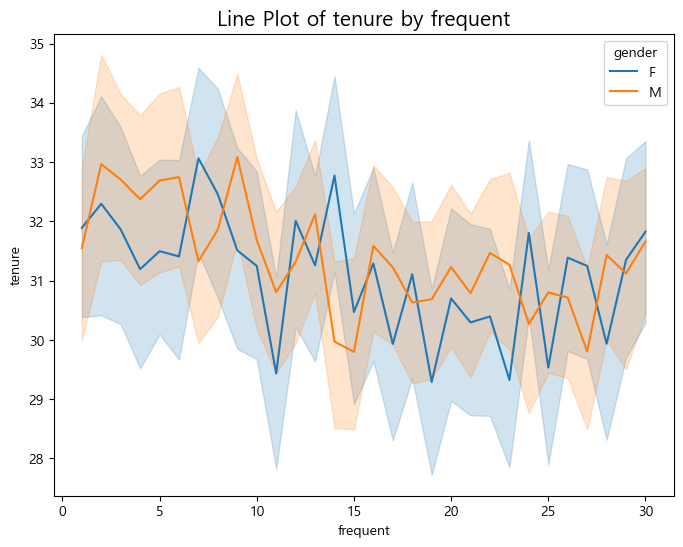

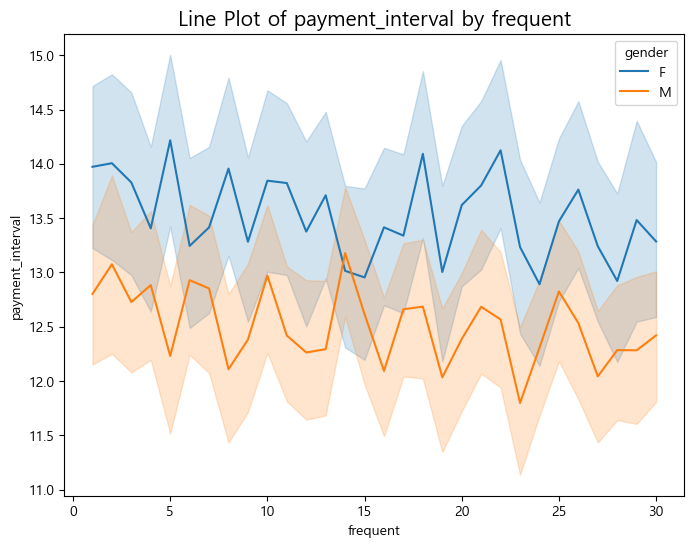

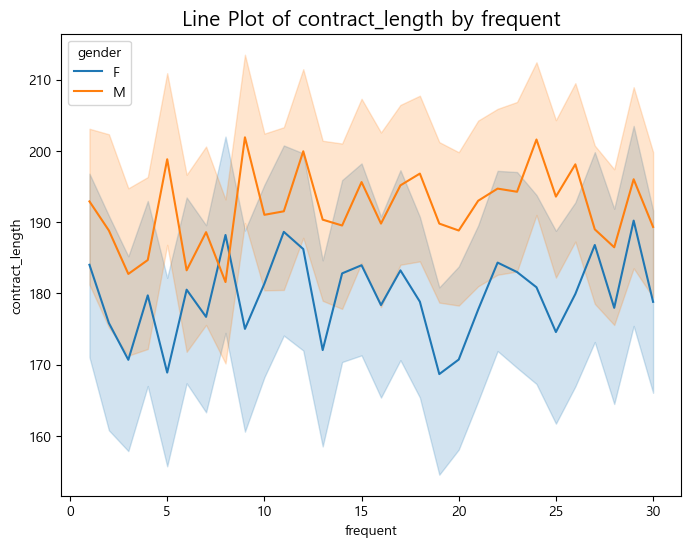

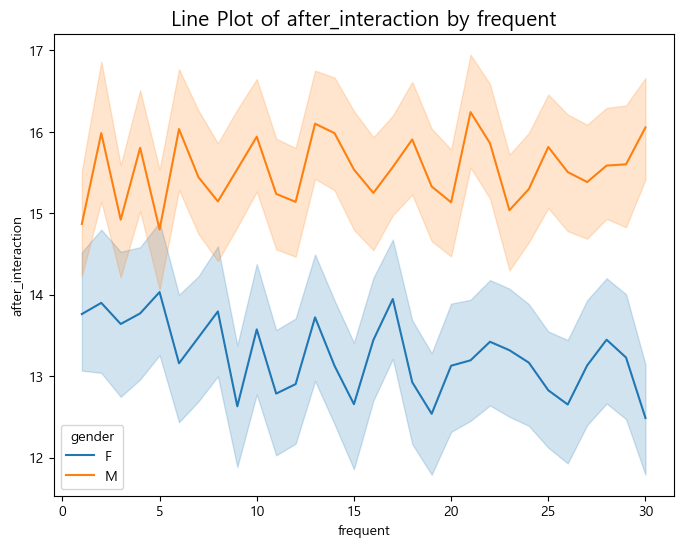

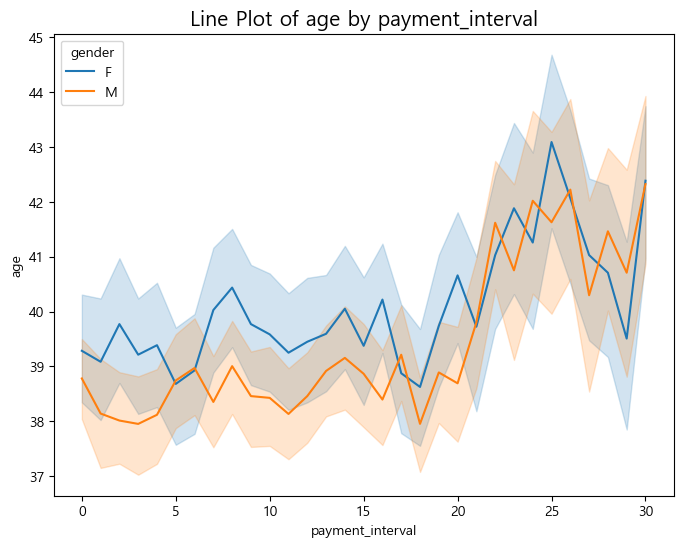

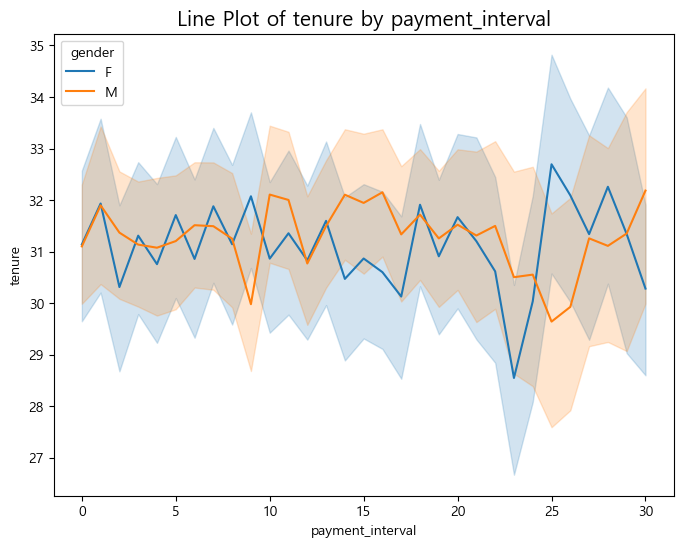

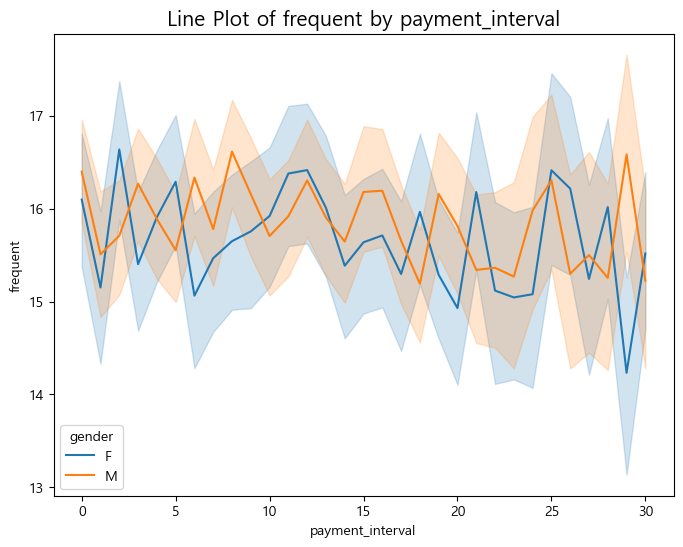

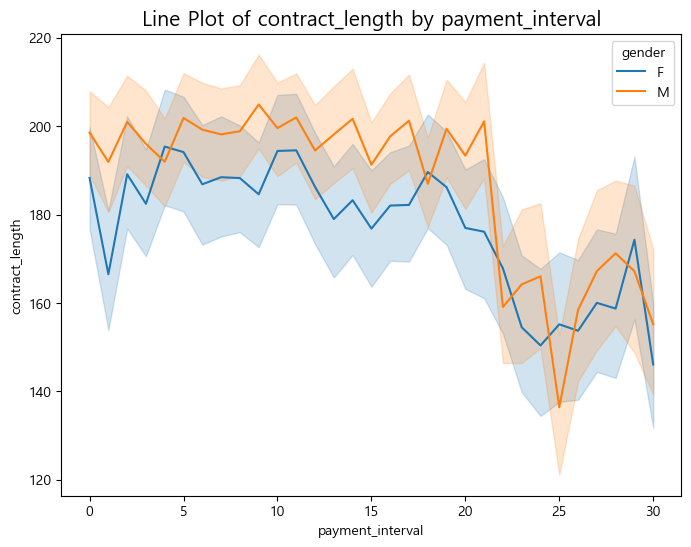

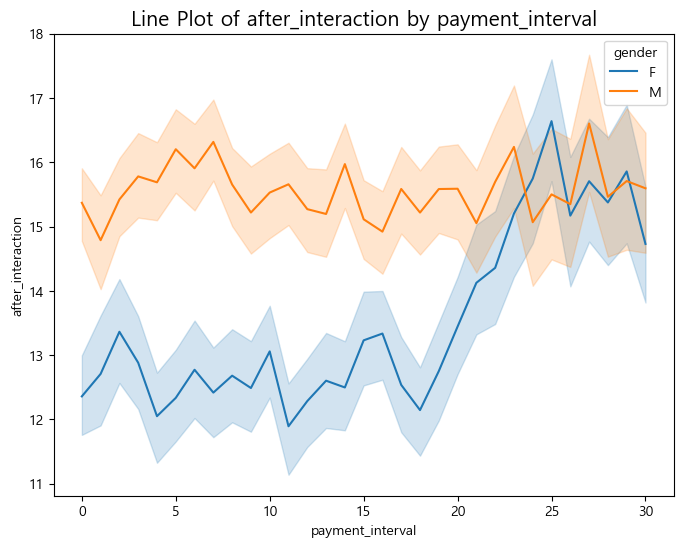

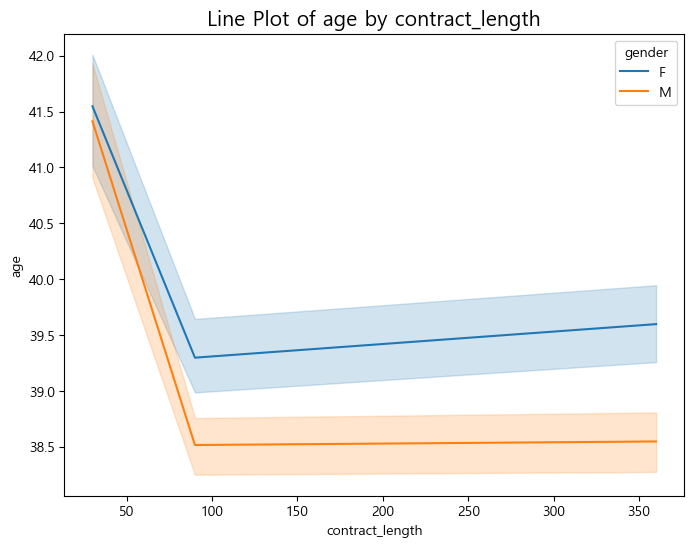

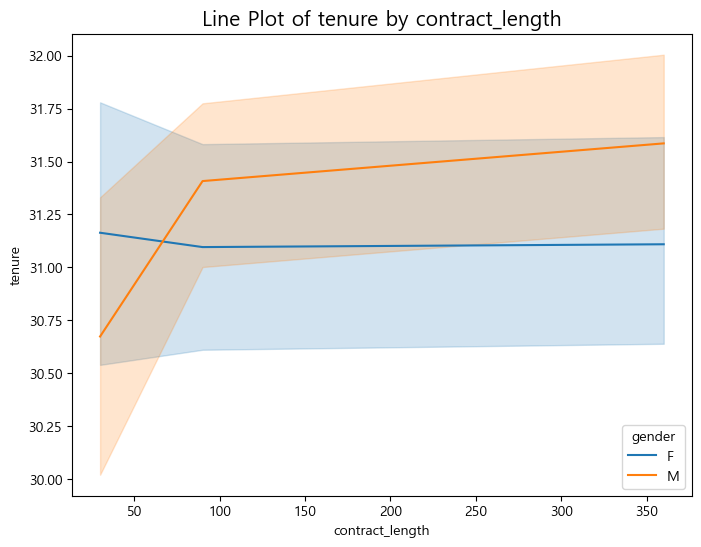

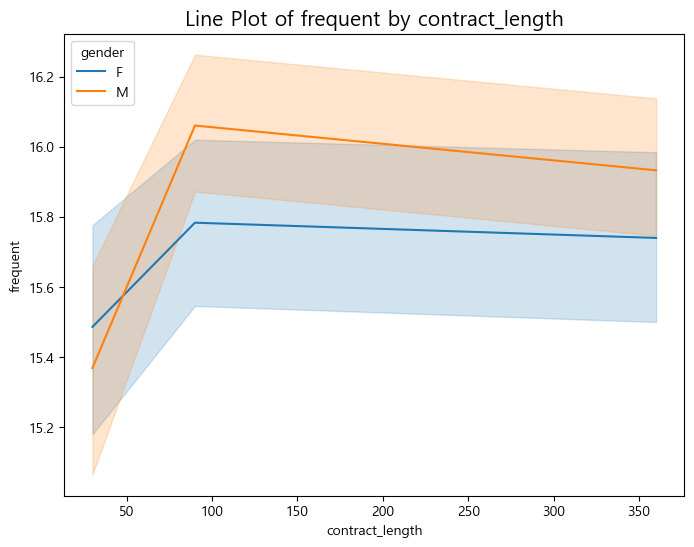

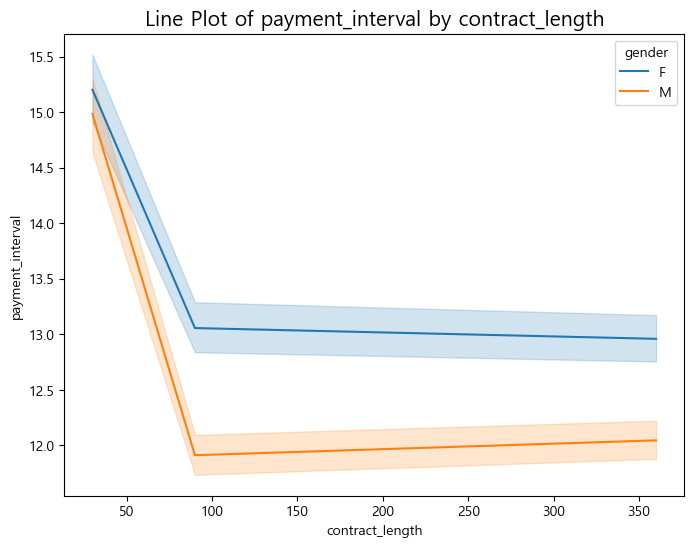

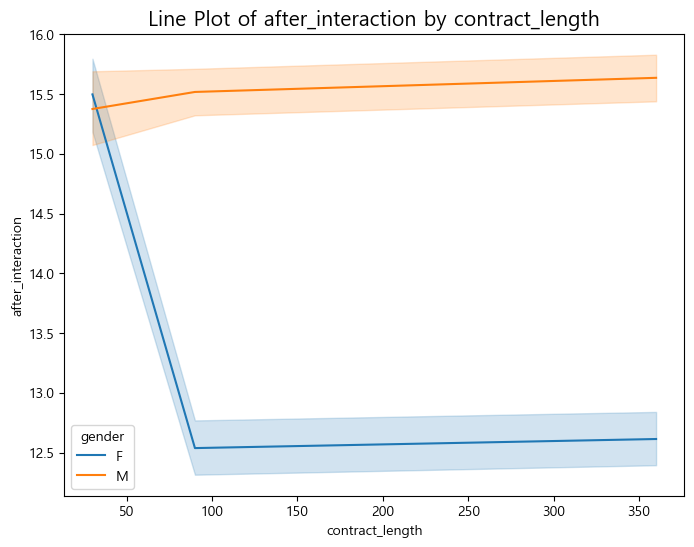

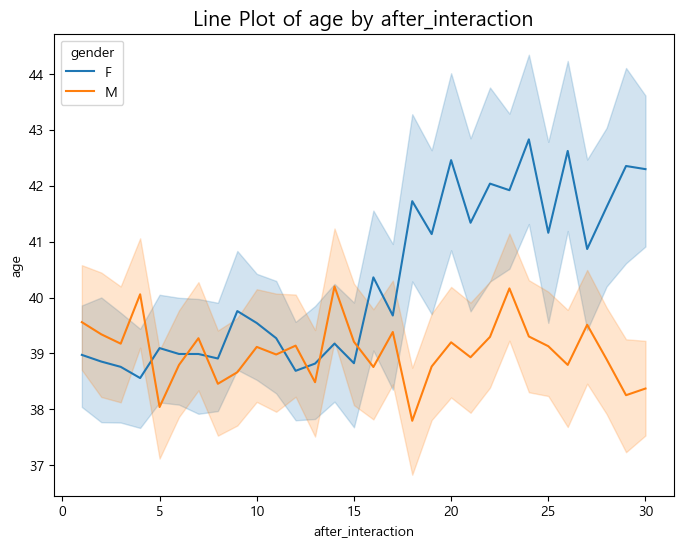

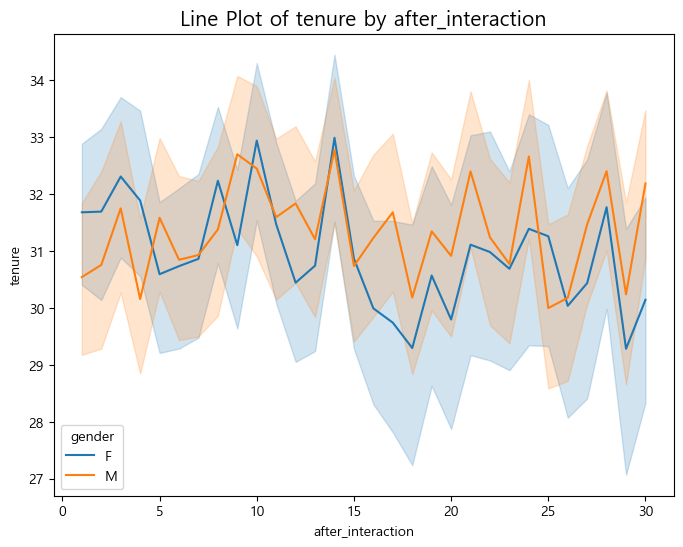

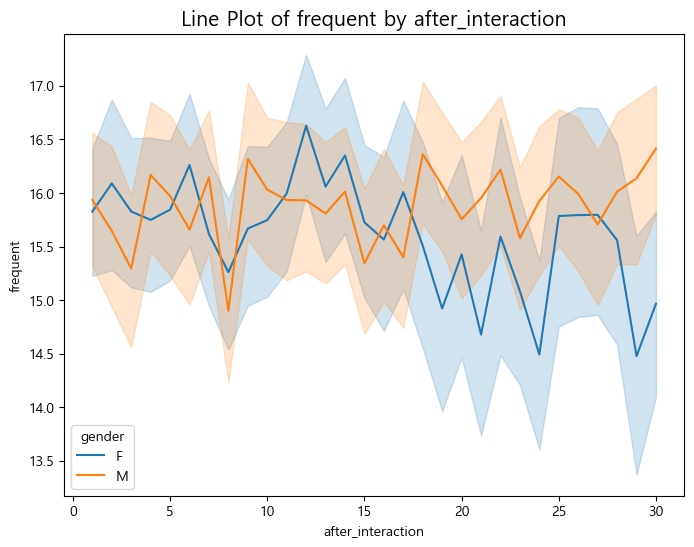

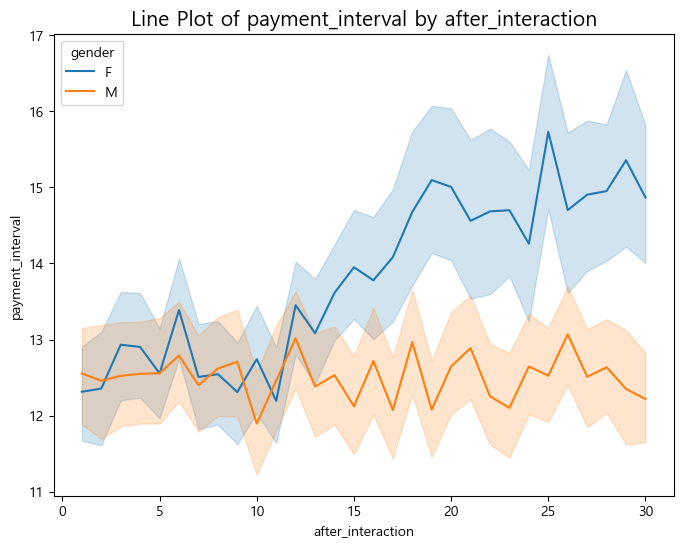

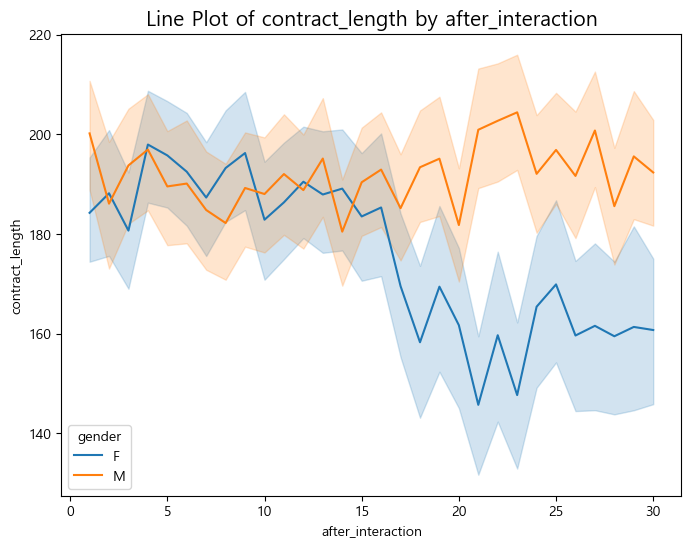

In [13]:
# 성별별로 차이가 있나?
from itertools import permutations

var_combinations = permutations(numerical_vars, 2)

for x_var, y_var in var_combinations:
    plt.figure(figsize=(8, 6)) # 각 그래프를 새로운 창에 그리기 위해 figure 생성
    
    sns.lineplot(
        x=x_var,
        y=y_var,
        hue='gender',
        data=train
    )
    
    plt.title(f'Line Plot of {y_var} by {x_var}', fontsize=15)
    plt.show()


# 피처 엔지니어링

In [14]:
train.head()

ID   age gender  tenure  frequent  payment_interval  \
0  TRAIN_00000  54.0      F    47.0      22.0               8.0   
1  TRAIN_00001  30.0      M    16.0      15.0               5.0   
2  TRAIN_00002  29.0      M     8.0      30.0              21.0   
3  TRAIN_00003  38.0      F    38.0      23.0              10.0   
4  TRAIN_00004  25.0      F    52.0       3.0              17.0   

  subscription_type  contract_length  after_interaction  support_needs  
0            member               90               25.0              0  
1               vip              360               23.0              0  
2              plus               30               21.0              0  
3               vip               90                6.0              0  
4            member               30                1.0              2

In [15]:
print(train['contract_length'].max())

360


In [ ]:
query = """
SELECT 
    age,
    gender,
    tenure AS total_month,
    frequent AS total_day,
    payment_interval,
    subscription_type,
    contract_length,
    after_interaction,
    support_needs, 
    frequent / 30 AS MPR,
    tenure / age AS membership_duration_ratio ,
    payment_interval/ 30 AS late_payment_rate,
    support_needs
FROM train;
"""

train_fe = duckdb.query(query).to_df()
train_fe.head()


# ID : 샘플별 고유 ID
# age : 고객 나이
# gender : 고객 성별
# tenure : 고객이 서비스를 이용한 총 기간 (개월)
# frequent : 고객의 서비스 이용일 (1~30) 최근 한달 이용일로 추정
# payment_interval : 고객의 결제 지연일 (0~30) 최근 한달 연체일로 추정정
# subscription_type : 고객의 서비스 등급
# contract_length : 고객의 서비스 계약 기간 (30~360)
# after_interaction : 고객이 최근 서비스 이용으로부터 경과한 기간 (일) (1~30)
# support_needs : 고객의 지원 필요도 (0 : 낮음 , 1 : 중간 , 2 : 높음)
#frequent / 30 AS MPR : 최근 1달간 이용 비율
#tenure / age AS membership_duration_ratio : 고객이 연령 대비 이용한 개월수
#payment_interval/ 30 AS late_payment_rate : 최근 1달간 연체율
#support_needs : TARGET

age gender  total_month  total_day  payment_interval subscription_type  \
0  54.0      F         47.0       22.0               8.0            member   
1  30.0      M         16.0       15.0               5.0               vip   
2  29.0      M          8.0       30.0              21.0              plus   
3  38.0      F         38.0       23.0              10.0               vip   
4  25.0      F         52.0        3.0              17.0            member   

   contract_length  after_interaction  support_needs       MPR  \
0               90               25.0              0  0.733333   
1              360               23.0              0  0.500000   
2               30               21.0              0  1.000000   
3               90                6.0              0  0.766667   
4               30                1.0              2  0.100000   

   membership_duration_ratio  late_payment_rate  support_needs_1  
0                   0.870370           0.266667                0  
1                   0.533333           0.166667                0  
2                   0.275862           0.700000                0  
3                   1.000000           0.333333                0  
4                   2.080000           0.566667                2

In [23]:
test.head()

ID   age gender  tenure  frequent  payment_interval  \
0  TEST_00000  18.0      M    40.0       6.0              15.0   
1  TEST_00001  40.0      M    41.0      23.0               0.0   
2  TEST_00002  59.0      F    30.0       1.0              21.0   
3  TEST_00003  38.0      M     2.0      10.0               0.0   
4  TEST_00004  30.0      M    28.0      21.0              20.0   

  subscription_type  contract_length  after_interaction  
0            member               30               18.0  
1            member               90               16.0  
2            member              360               25.0  
3            member               30               18.0  
4            member              360               28.0

In [26]:
query = """
SELECT 
    age,
    gender,
    tenure AS total_month,
    frequent AS total_day,
    payment_interval,
    subscription_type,
    contract_length,
    after_interaction, 
    frequent / 30 AS MPR,
    tenure / age AS membership_duration_ratio ,
    payment_interval/ 30 AS late_payment_rate
FROM test;
"""

test_fe = duckdb.query(query).to_df()
test_fe.head()

age gender  total_month  total_day  payment_interval subscription_type  \
0  18.0      M         40.0        6.0              15.0            member   
1  40.0      M         41.0       23.0               0.0            member   
2  59.0      F         30.0        1.0              21.0            member   
3  38.0      M          2.0       10.0               0.0            member   
4  30.0      M         28.0       21.0              20.0            member   

   contract_length  after_interaction       MPR  membership_duration_ratio  \
0               30               18.0  0.200000                   2.222222   
1               90               16.0  0.766667                   1.025000   
2              360               25.0  0.033333                   0.508475   
3               30               18.0  0.333333                   0.052632   
4              360               28.0  0.700000                   0.933333   

   late_payment_rate  
0           0.500000  
1           0.000000  
2           0.700000  
3           0.000000  
4           0.666667

In [27]:
#범주형 변수 인코딩
train_fe['gender'] = train_fe['gender'].map({'F':0, "M": 1})
test_fe['gender'] = test_fe['gender'].map({'F':0, "M": 1})

train_fe['subscription_type'] = train_fe['subscription_type'].map({'member' : 0, 'plus' : 1, 'vip' : 2})
test_fe['subscription_type'] = test_fe['subscription_type'].map({'member' : 0, 'plus' : 1, 'vip' : 2})


In [ ]:
x_train = train_fe.drop(columns =['support_needs','support_needs_1'])
x_test = test_fe
y_train = train_fe['support_needs']

0        0
1        0
2        0
3        0
4        2
        ..
30853    1
30854    2
30855    0
30856    0
30857    2
Name: support_needs, Length: 30858, dtype: int64

In [30]:
x_train.head()

age  gender  total_month  total_day  payment_interval  subscription_type  \
0  54.0       0         47.0       22.0               8.0                  0   
1  30.0       1         16.0       15.0               5.0                  2   
2  29.0       1          8.0       30.0              21.0                  1   
3  38.0       0         38.0       23.0              10.0                  2   
4  25.0       0         52.0        3.0              17.0                  0   

   contract_length  after_interaction       MPR  membership_duration_ratio  \
0               90               25.0  0.733333                   0.870370   
1              360               23.0  0.500000                   0.533333   
2               30               21.0  1.000000                   0.275862   
3               90                6.0  0.766667                   1.000000   
4               30                1.0  0.100000                   2.080000   

   late_payment_rate  
0           0.266667  
1           0.166667  
2           0.700000  
3           0.333333  
4           0.566667

In [42]:
y_train.head()

114    0.512875
173    0.818869
5      0.896995
126    0.915002
117    0.995734
dtype: float64

In [44]:
x_test.head()

age    gender  total_month  total_day  payment_interval  \
95   0.649509  0.804414     0.715100   0.593158          0.053348   
15   0.295290  0.232384     0.281004   0.803483          0.929228   
30   0.747444  0.473810     0.057844   0.957790          0.942724   
158  0.665056  0.556578     0.342731   0.134576          0.094419   
128  0.050350  0.052765     0.692011   0.457929          0.226522   

     subscription_type  contract_length  after_injection       MPR  \
95            0.454764         0.674786         0.677532  0.373123   
15            0.405103         0.906111         0.321496  0.476437   
30            0.785190         0.991328         0.544482  0.962768   
158           0.831518         0.918398         0.649788  0.103434   
128           0.613970         0.252858         0.577632  0.359209   

     membership_duration_ratio  late_payment_rate  
95                    0.941692           0.167357  
15                    0.226029           0.640476  
30                    0.075605           0.365681  
158                   0.402027           0.728939  
128                   0.823552           0.820696

# XGC로 모델링 할거기때문에 scailing 진행하지 않음
# 트리 기반 모델이니까 정규성 신경쓰지 않아도 됨

###  알고리즘의 선택 기준
머신러닝 알고리즘을 선택할 때는 데이터의 특성과 목표에 따라 가장 적합한 모델을 선택하는 것이 중요해요. 네 가지 알고리즘(SVM, Decision Tree, Random Forest, Gradient Boosting)은 각기 다른 강점과 특성을 가지고 있어서 상황에 맞게 활용할 수 있어요. 아래는 주요 선택 기준입니다.

 

SVM (Support Vector Machine)은 고차원 데이터와 샘플 크기가 적은 상황에서 적합한 알고리즘이에요. 고차원 데이터를 효과적으로 처리하며, 커널 기법을 통해 비선형 문제도 해결할 수 있는 유연성을 가지고 있습니다. 특히 텍스트 분류나 이미지 분류와 같은 이진 분류 문제에서 강력한 성능을 발휘합니다. 하지만 데이터 샘플이 많거나 Feature 수가 지나치게 많아지면 학습 속도가 느려지고, 하이퍼파라미터(C와 커널 유형) 튜닝에 민감하다는 점은 한계로 작용할 수 있어요.

 

Decision Tree는 단순하고 해석 가능한 모델이 필요한 경우에 적합합니다. 트리 구조 덕분에 데이터를 빠르게 분석하고, 시각화하여 직관적으로 이해할 수 있는 점이 큰 장점이에요. 분류와 회귀 문제 모두에서 활용 가능하며, 데이터 전처리가 부족하거나 결측값이 포함된 데이터에서도 잘 작동합니다. 그러나 단독으로 사용할 경우 트리가 너무 깊어질 수 있어 과적합 위험이 있고, 성능이 제한적이라는 점을 염두에 두어야 합니다.

 

Random Forest는 안정적이고 정확한 결과를 원할 때 선택하기 좋은 알고리즘이에요. 여러 Decision Tree를 결합해 노이즈와 복잡한 데이터에 강하며, 과적합을 방지하면서도 높은 정확도를 제공합니다. 또한 결측값이 있거나 Feature가 많은 데이터에서도 잘 작동합니다. 다만, 여러 Tree를 조합하는 과정에서 학습 속도가 느리고, 모델이 내린 결정을 해석하기 어렵다는 단점이 있어요.

 

Gradient Boosting은 데이터가 복잡하거나 대규모 데이터셋에서 최고의 성능이 필요할 때 선택하기 적합합니다. 약한 학습기들을 순차적으로 학습하여 높은 예측 성능을 제공하며, 데이터의 복잡한 패턴을 잘 포착하는 강점을 가지고 있어요. 특히 머신러닝 대회(Kaggle 등)에서 자주 사용되는 모델로, 분류와 회귀 문제 모두에서 탁월한 성능을 발휘합니다. 하지만 학습 속도가 느리고, 과적합의 위험이 있으므로 적절한 하이퍼파라미터 튜닝이 필수적입니다.




n_estimators : 학습 모델의 수, 많아질수록 성능 향상의 가능성이 있으나, 속도가 느려짐

learning_rate : 학습률, 너무 크면 gradient 발산의 가능성이 있으며, 너무 작으면 학습이 느림

max_depth : 최대 탐색 깊이, 너무 크면 과적합의 가능성, 너무 작으면 학습 성능 저하

min_samples_split : 분할 종료 최소 샘플 수, 큰 수면 과적합을 막지만 학습 성능 저하 가능성

min_samples_leaf : leaf node가 되기 위한 최소 샘플 수, min_samples_split과 비슷한 용도

random_state : 특정 숫자로 고정 시에 실행 시마다 고정된 결과 반환

# 종속변수 weights 생각해야함, 클래스 불균형이 있으니까!
# 방법: 언더샘플링, 오버샘플링, 가중치
# 가중치를 줍시다

In [70]:
from sklearn.utils.class_weight import compute_class_weight
# 1. y_train에 있는 각 클래스의 고유값과 그 개수를 확인
y_train.value_counts()
classes_y_train = [0,1,2]
counts = [14297, 8297, 8297]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
print("클래스 종류:", np.unique(y_train))
print("계산된 클래스별 가중치:", class_weights)


weights = np.zeros(len(y_train))
for i, cls in enumerate(np.unique(y_train)):
    weights[y_train == cls] = class_weights[i]

클래스 종류: [0 1 2]
계산된 클래스별 가중치: [0.71945163 1.2397252  1.2446757 ]


In [71]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# 클래스 불균형 고려: f1_macro, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='macro')

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 200, 400, 800],
    'learning_rate': [0.03, 0.05, 0.1, 0.15]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        tree_method='gpu_hist',
        random_state=42,
        objective='multi:softmax',  # 직접 클래스 예측
        num_class=3,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0
    ),
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=1
)

grid_search.fit(x_train, y_train, sample_weight=weights)
print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 f1_macro:", grid_search.best_score_)

best_model = grid_search.best_estimator_
preds_tuned = best_model.predict(x_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
최적 하이퍼파라미터: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
최고 f1_macro: 0.5051292852588433


In [72]:
preds_final = best_model.predict(x_test)

# 교차검증 OOF f1_macro도 출력
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, x_train, y_train, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print(f"CV f1_macro: {scores.mean():.4f} +/- {scores.std():.4f}")

# 제출 파일 생성
submission = pd.read_csv(data_path/'sample_submission.csv')
submission['support_needs'] = preds_final
submission.to_csv('xgb_tuned_submission.csv', index=False)

print("XGBoost 최적 모델 예측 완료 및 제출 파일 생성!")

CV f1_macro: 0.4064 +/- 0.0045
XGBoost 최적 모델 예측 완료 및 제출 파일 생성!
